In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg, signal
import ae353_segbot

**Segbot Dimensions**

The following section contains specifications of the segbot which are used to calculate its dynamics. This code is originally from ```DeriveEOM.ipynb```.

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Acceleration of gravity
g = 9.81

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

**State-Space Model**

This section creates a state-space model for the segbot. The code for the ```f``` matrix is also from ```DeriveEOM.ipynb```, except for the addition of ```[thetadot]```, which effectively converts the last equation of the system into two first-order ordinary differential equations.

Code is included (```F_num```) to verify the selection of equilibrium points and to calculate the A (```A_num```) and B (```B_num```) matrices for state-space form. 

In [3]:
(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_L,
 tau_R) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_L, tau_R', real=True)

M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + thetadot**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * thetadot - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [thetadot],
                [f]])

# Equilibrium values
e_l_e = 0.
e_h_e = 0.
v_e = 5.9
w_e = 0.
theta_e = 0.
thetadot_e = 0.
tau_L_e = 0.
tau_R_e = 0.

# Verify equilibrium
F_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R), f)
F = F_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e)
# print(f)

# A matrix
A_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R), f.jacobian([e_l, e_h, theta, v, w, thetadot]))
A = A_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e)
# print(A)

# B matrix
B_num = sym.lambdify((e_l, e_h, v, w, theta, thetadot, tau_L, tau_R), f.jacobian([tau_L, tau_R]))
B = B_num(e_l_e, e_h_e, v_e, w_e, theta_e, thetadot_e, tau_L_e, tau_R_e)
# print(B)

# Equilibrium states
m_e = np.array([[e_l_e], [e_h_e], [theta_e], [v_e], [w_e], [thetadot_e]])

**Linear Quadratic Regulator (LQR)**

This section creates a ```K``` matrix using the LQR method. The ```Q``` matrix, a 6x6 diagonal matrix, has been found using the LQR cost optimizer, which is further below. Only the first element of the ```Q``` matrix has been modified manually. The ```R``` matrix is a 2x2 identity matrix, as it is desired to weigh both inputs (applied torque to each wheel) the same.

In [4]:
Q = np.diag([439, 423, 262, 1, 10, 33])
R = np.eye(2)
P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P

**Place Poles (Unused)**

This section contains code for placing eigenvalues in array ```p``` to create a ```K``` matrix, given ```A``` and ```B```. This code is not used to generate the final controller.

In [5]:
# p = np.array([-10, -0.1, -0.5, -0.8, -40, -5])
# K = signal.place_poles(A, B, p).gain_matrix
# print(K.tolist())

**Other K Matrix (Unused)**

This section contains ```K``` matrices that were tuned by hand at the very beginning of the project. This code is not used to generate the final controller.

In [6]:
# This K matrix does not work well above 4 m/s
# K = np.array([[-60., -90., -40., -1., -30., -50.],
#               [60., 90., -40., -1., 30., -50.]])

**Stability & Controllability**

This section provides the rank of the controllability matrix. If rank is equal to the number of rows of ```W``` (in this case 6), then the matrix is full rank and the system is controllable.

This section also provides the eigenvalues of the matrix ```F```. If all eigenvalues of ```F``` have negative real part, then the system converges. Complex eigenvalues indicate marginal stability.

In [7]:
mp = np.linalg.matrix_power
W = np.block([[B, A @ B, mp(A, 2) @ B, mp(A, 3) @ B, mp(A, 4) @ B, mp(A, 5) @ B]])
rank = np.linalg.matrix_rank(W)
print(rank)

F = A - B @ K
p = linalg.eigvals(F)
print(p.tolist())

6
[(-420.9277777311025+0j), (-3.887278294524961+4.33205915235558j), (-3.887278294524961-4.33205915235558j), (-5.419194859176391+0j), (-3.7720699663645942+0j), (-0.18670279776527685+0j)]


**Simulation**

The following line creates an instance of the simulation. The kernel must be restarted before running this line again.

In [8]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=True)

**Controller**

Below is the controller class for the segbot. It takes arguments ```K```, the gain matrix, ```m_e```, the equilibrium state, and ```robot.dt```, the simulation's time step. The ```run()``` function uses state feedback control to find ```u```, the input, which contains the respective torque to each wheel.

In [9]:
class RobotController:
    def __init__(self, K, m_e, dt=0.01):
        self.dt = dt   
        self.K = K
        self.m_e = m_e
    
    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        m = np.array([[lateral_error], [heading_error], [pitch_angle], [forward_speed], [turning_rate], [pitch_rate]])
        x = m - m_e
        u = -K @ x
        tau_left = u[0, 0]  # <--- torque applied to left wheel (positive means rolling forward)
        tau_right = u[1, 0] # <--- torque applied to right wheel (positive means rolling forward)
        return tau_left, tau_right

In [10]:
# Create instance of controller
controller = RobotController(K, m_e, dt=robot.dt)

**LQR Cost Optimizer**

This section is a script designed to find an effective ```Q``` matrix for the LQR controller above. It is a for loop in which runs a nonlinear simulation (essentially a non-GUI and plot-free version of the full PyBullet simulation) using a randomly generated ```Q``` matrix and calculates the cost. After reaching the iteration limit, the lowest cost and corresponding ```Q``` matrix a printed. Initial conditions in ```robot.reset()``` should match those intended for the full simulation.

Code blocks to generate ```A``` and ```B``` as well as the controller class (do not create an instance) must be run before running this section. Do not run this section if you only intend to view the full simulation. The kernel must also be restarted before any line that creates an instance of the simulation is run again.

In [ ]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, display=False)

ri = np.random.randint
Q_best = np.array([])
cost_min = 1000000000000

for i in range(10000):
    cost_curr = 0.
    Q = np.diag([ri(1, 500), ri(1, 500), ri(1, 500), ri(1, 500), ri(1, 500), ri(1, 500)])
    R = np.eye(2)
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    controller = RobotController(K, m_e, dt=robot.dt)

    robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.,            # angle that the track is sloped (rad)
            initial_speed=v_e,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0.)           # initial pitch angle of chassis (rad)

    # Choose how long we want to run the simulation, and
    # compute the corresponding number of time steps
    run_time = 15.
    num_steps = int(run_time/robot.dt)

    # Run the simulation loop
    start_time = time.time()
    for step in range(num_steps):
        # Get the current time
        t = robot.dt * step

        # Get the sensor measurements
        (lateral_error,
         heading_error,
         forward_speed,
         turning_rate,
         pitch_angle,
         pitch_rate) = robot.get_sensor_measurements()

        # Choose the actuator command (by running the controller)
        tau_left_command, tau_right_command = controller.run(lateral_error,
                                                             heading_error,
                                                             forward_speed,
                                                             turning_rate,
                                                             pitch_angle,
                                                             pitch_rate)

        # Apply the actuator commands
        tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)
        
        # Calculate input, u, from state, x, and gain matrix, K
        m = np.array([[lateral_error], [heading_error], [pitch_angle], [forward_speed], [turning_rate], [pitch_rate]])
        x = m - m_e
        u = -K @ x
        # Calculate cost integral for current iteration by multiplying instantaneous cost by time step and summing
        cost_curr += (np.transpose(x) @ Q @ x + np.transpose(u) @ R @ u) * robot.dt

        # Simulate one time step
        robot.step(t=(start_time + (robot.dt * (step + 1))))
        
    if cost_curr < cost_min:
        cost_min = cost_curr
        Q_best = Q
    # Just to check if still running
    print(i)

print(cost_min)
print(Q_best)

**Simulation**

This section runs the full simulation. This is used for both testing controller candidates and for performing the verification task to demonstrate that the requirement has been met. The code is taken from ```SegbotDemo.ipynb```. As part of the requirement/target is that the lap is completed within 12 seconds and that the segbot may begin at equilibrium speed, the ```initial_speed``` argument in ```robot.reset()``` is set to the equilibrium speed and the ```run_time``` variable is set to 12 seconds.

The additional question investigated is what happens when ```initial_speed``` is zero. This takes longer, so ```run_time``` should be set to 17.5 seconds in this case. This is long enough to see the robot either finish or fall off the track.

In [11]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.,            # angle that the track is sloped (rad)
            initial_speed=v_e,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0.)           # initial pitch angle of chassis (rad)

# Choose a camera view
# robot.camera_sideview()
# robot.camera_topview()
robot.camera_chaseview(yaw=270.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 12.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'lateral_error': np.empty(num_steps, dtype=float),
    'heading_error': np.empty(num_steps, dtype=float),
    'forward_speed': np.empty(num_steps, dtype=float),
    'turning_rate': np.empty(num_steps, dtype=float),
    'pitch_angle': np.empty(num_steps, dtype=float),
    'pitch_rate': np.empty(num_steps, dtype=float),
    'tau_left_command': np.empty(num_steps, dtype=float),
    'tau_right_command': np.empty(num_steps, dtype=float),
    'tau_left': np.empty(num_steps, dtype=float),
    'tau_right': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error,
     heading_error,
     forward_speed,
     turning_rate,
     pitch_angle,
     pitch_rate) = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau_left_command, tau_right_command = controller.run(lateral_error,
                                                         heading_error,
                                                         forward_speed,
                                                         turning_rate,
                                                         pitch_angle,
                                                         pitch_rate)
    
    # Apply the actuator commands
    tau_left, tau_right = robot.set_actuator_commands(tau_left_command, tau_right_command)
    
    # Log the data from this time step
    data['t'][step] = t
    data['lateral_error'][step] = lateral_error
    data['heading_error'][step] = heading_error
    data['forward_speed'][step] = forward_speed
    data['turning_rate'][step] = turning_rate
    data['pitch_angle'][step] = pitch_angle
    data['pitch_rate'][step] = pitch_rate
    data['tau_left_command'][step] = tau_left_command
    data['tau_right_command'][step] = tau_right_command
    data['tau_left'][step] = tau_left
    data['tau_right'][step] = tau_right
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

**Plotting**

The code for plotting results is contained in this section. Four plots are generated within a single figure. The code is adapted from ```SegbotDemo.ipynb```.

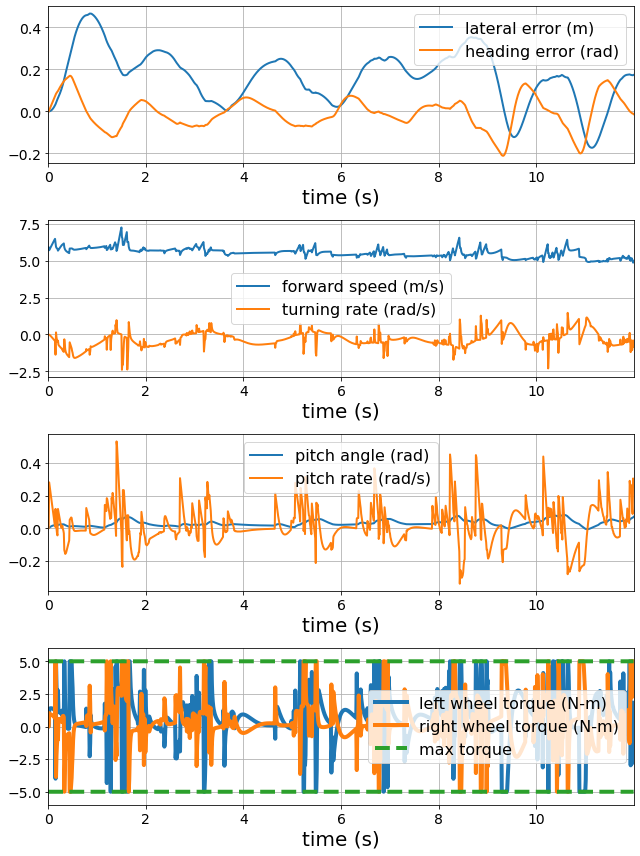

In [12]:
# Create a figure with four subplots
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=False)

# First subplot
ax[0].plot(data['t'], data['lateral_error'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Second subplot
ax[1].plot(data['t'], data['forward_speed'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties
for i in range(4):
    ax[i].set_xlabel('time (s)', fontsize=20)
    ax[i].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()